In [1]:
import sys
sys.path.insert(0, '../')

from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload

In [52]:
%autoreload 2
data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
# data normalization
data = data - np.mean(data, axis=0)

target = np.genfromtxt('iris.csv', delimiter=',', usecols=(4), dtype=str)
t = np.zeros(len(target), dtype=int)
t[target == 'setosa'] = 0
t[target == 'versicolor'] = 1
t[target == 'virginica'] = 2

# Initialization and training
som = MiniSom(15, 15, 4, sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 1000, verbose=True)

 [  909 / 1000 ]  91% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.17828509195657782


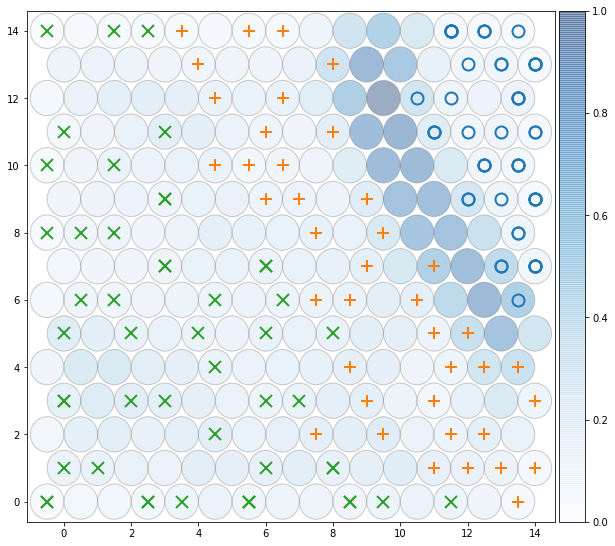

In [82]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        hex = Ellipse((xx[(i, j)], yy[(i, j)]), width=1., height=1.05, 
                      facecolor=cm.Blues(umatrix[i, j]), alpha=.4, edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    w = som.winner(x)  # getting the winner
    # palce a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w)
    plt.plot(wx, wy, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)


plt.xlim([-1.1, weights.shape[0]-.4])
plt.ylim([-0.6, weights.shape[1]-.4])

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, orientation='vertical', alpha=.4)
plt.gcf().add_axes(ax_cb)
plt.savefig('resulting_images/som_iris_hex.png')
plt.show()